# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#8b4513;">Pea Plant Disease Classification </p>

### Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 60

### Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Pea_Plant_disease_Detection/training/pea_plant_dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
     batch_size=BATCH_SIZE
)

Found 1432 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['DOWNY_MILDEW_LEAF', 'FRESH_LEAF', 'LEAFMINNER_LEAF', 'POWDER_MILDEW_LEAF']

In [6]:
len(dataset)

45

In [7]:
# Batch size = 32
45*32

1440

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 3 2 2 0 2 1 1 1 1 3 3 1 3 1 3 2 2 1 1 1 2 2 3 2 0 2 2 1 2 3]


In the above cell 0,1,2,3 represents 4 classes in datset

### Visualize some of the images from our dataset

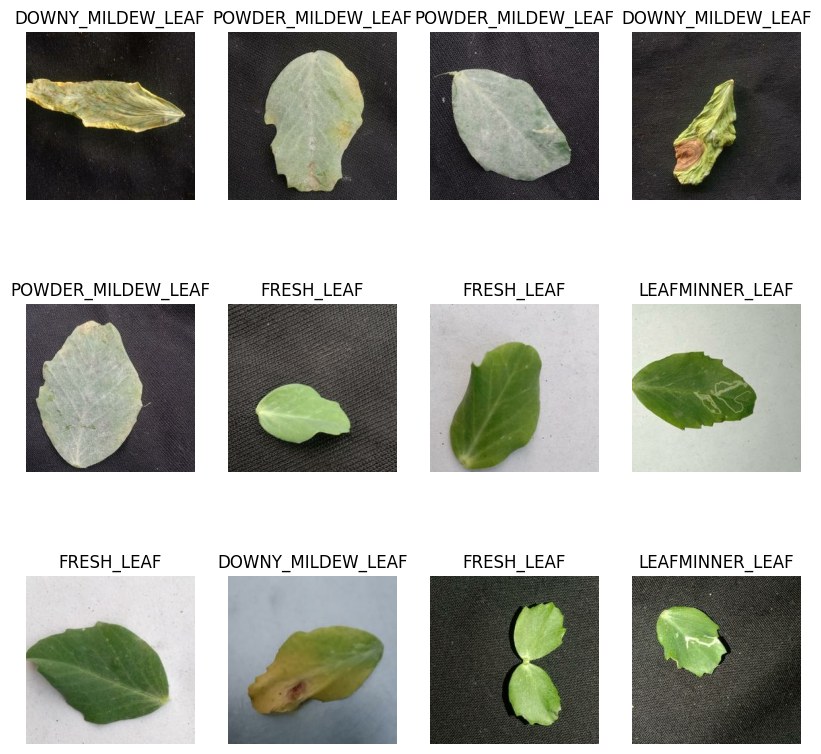

In [9]:

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [10]:
len(dataset)

45

In [11]:
# Function for splitting of Data int train, validation and test

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

36

In [14]:
len(val_ds)

4

In [15]:
len(test_ds)

5

### Cache, Shuffle, and Prefetch the Dataset

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model
#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
])

## Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.2941 - loss: 1.3712 - val_accuracy: 0.5078 - val_loss: 1.0825
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4484 - loss: 1.1256 - val_accuracy: 0.4922 - val_loss: 1.0658
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5133 - loss: 1.0556 - val_accuracy: 0.5625 - val_loss: 0.9732
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5314 - loss: 0.9959 - val_accuracy: 0.5625 - val_loss: 1.1039
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5544 - loss: 0.9936 - val_accuracy: 0.6016 - val_loss: 0.8568
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5881 - loss: 0.9090 - val_accuracy: 0.6875 - val_loss: 0.7009
Epoch 7/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6353 - loss: 0.8188 - val_accuracy: 0.7109 - val_loss: 0.7232
Epoch 8/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6931 - loss: 0.7233 - val_accuracy: 0.7188 - 

### Evaluatuion with test dataset

In [24]:
scores = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9503 - loss: 0.1970


In [25]:
scores

[0.25194647908210754, 0.925000011920929]

## Plotting the Accuracy and Loss Curves

In [26]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 36}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
history.history['accuracy']

[0.3164335787296295,
 0.4414335787296295,
 0.49562937021255493,
 0.5262237787246704,
 0.5664335489273071,
 0.5917832255363464,
 0.6442307829856873,
 0.6931818127632141,
 0.7290209531784058,
 0.7491258978843689,
 0.7727272510528564,
 0.7255244851112366,
 0.7648601531982422,
 0.7963286638259888,
 0.8024475574493408,
 0.8059440851211548,
 0.8059440851211548,
 0.8277971744537354,
 0.8234265446662903,
 0.8277971744537354,
 0.8356643319129944,
 0.8050699234008789,
 0.8548951148986816,
 0.8627622127532959,
 0.8277971744537354,
 0.8251748085021973,
 0.8391608595848083,
 0.868881106376648,
 0.8583915829658508,
 0.8548951148986816,
 0.8601398468017578,
 0.8601398468017578,
 0.8347902297973633,
 0.868881106376648,
 0.8924825191497803,
 0.8723776340484619,
 0.8627622127532959,
 0.8776223659515381,
 0.8592657446861267,
 0.8846153616905212,
 0.8898601531982422,
 0.9291958212852478,
 0.9038461446762085,
 0.9082167744636536,
 0.9160839319229126,
 0.9178321957588196,
 0.9134615659713745,
 0.92919582128

In [31]:
len(history.history['accuracy'])

60

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

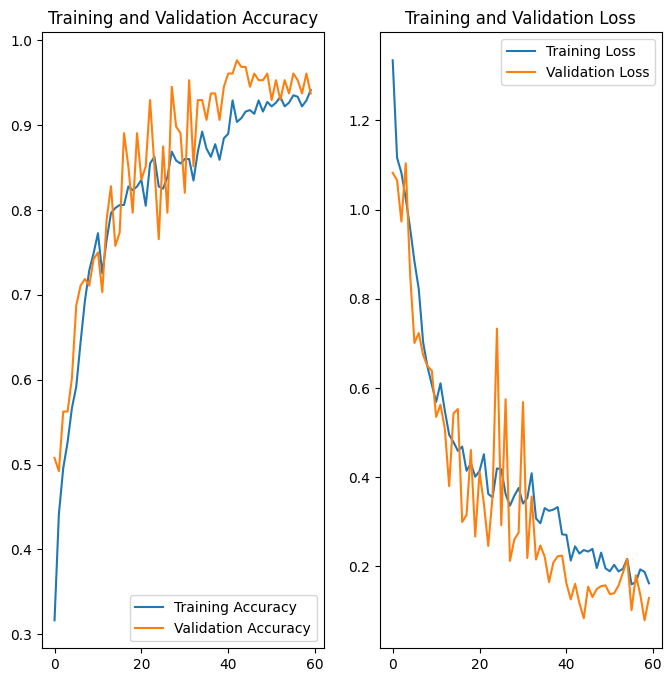

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: FRESH_LEAF
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
predicted label: FRESH_LEAF


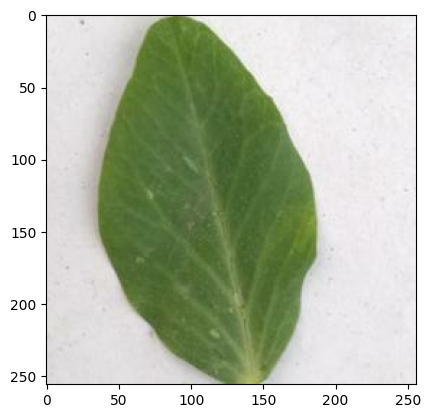

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


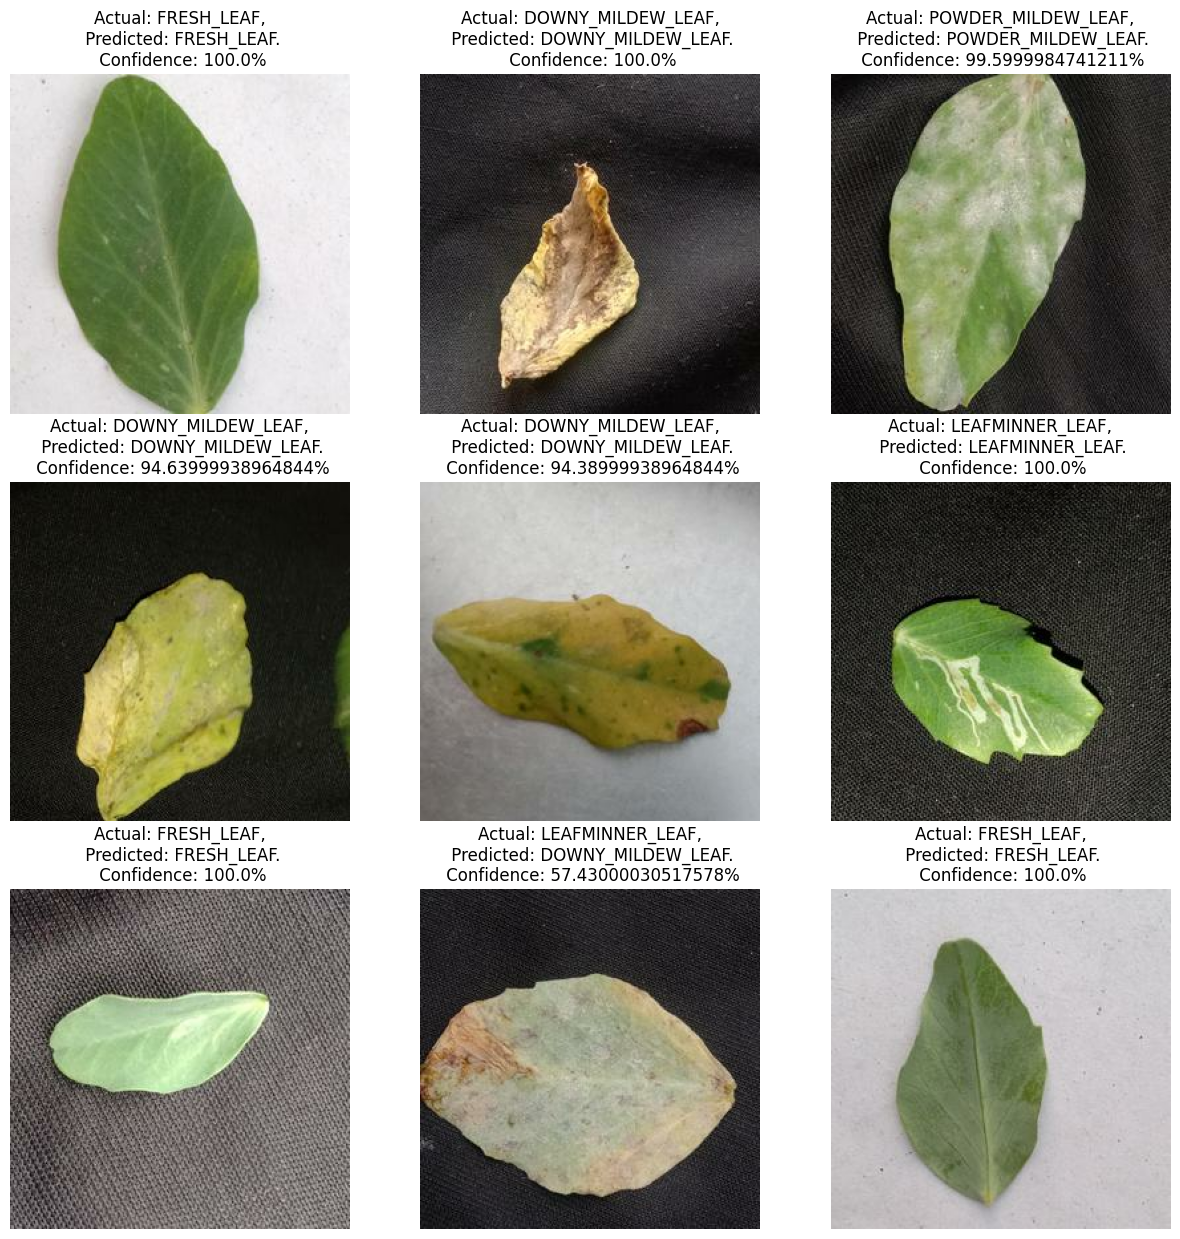

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

## Saving the Model

In [41]:
import os

# Get the next version number
existing_versions = [int(i) for i in os.listdir("/content/drive/MyDrive/Pea_Plant_disease_Detection/saved_models") if i.isdigit()]
model_version = max(existing_versions + [0]) + 1

# Save in SavedModel format (creates a directory with assets, variables, etc.)
model.export(f"/content/drive/MyDrive/Pea_Plant_disease_Detection/saved_models/{model_version}")

print(f"Model exported as version {model_version}")

Saved artifact at '/content/drive/MyDrive/Pea_Plant_disease_Detection/saved_models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136336154792336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136336154793104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136336154797136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136336154797904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136336154792528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136336154795792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136336154799056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136336154798288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136336154799440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136336154799248: TensorSpec(shape=(